<a href="https://colab.research.google.com/github/RAJESHVELAMALA/Project3/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_hub

In [ ]:
#Import Os and Basis Libraries
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
#Matplot Images
import matplotlib.image as mpimg
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
#Kernel Intilizer
from sklearn.preprocessing import LabelEncoder
# import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam , Adamax
#PreTrained Model
from tensorflow.keras.applications import *
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
# Correct import for ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Warnings Remove
import warnings
warnings.filterwarnings("ignore")

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping



# paellet
palette = ["#606060FF", "#D6ED17FF"]

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#from google.colab import files
#files.upload()


In [ ]:
#!unzip /content/sample_data/fast-food-classification-dataset/Train/foodclassification.zip -d /content/drive/MyDrive/fast-food-classification-dataset/

In [ ]:
def loadImages(path, filename):
  print("Loading images...")
  print("Reading the meta file containing all image file names")
  filenames_df = pd.read_csv(path+filename)
  base_path = path + "Images/"
  print(filenames_df.shape)
 # Create a empty list to hold images
  images = []
  filenames_df_success = []

  # Sort Dataset on id
  #filenames_df = filenames_df.sort_values(by=['id'])
  number_of_images = len(filenames_df)
  #number_of_images = 25

  for i in range(number_of_images):
      filename = filenames_df.iloc[i,0]
      path = base_path + filename+".jpg"
      print(f'{i} of {len(filenames_df)}: Attempting to import {path}')
      try:
          images.append(Image.open(path))
          filenames_df_success.append(filename)
      except:
          print(f'FAILED: {filename}')
  print(len(filenames_df_success))
  print("Images loaded!" + str(len(images)))
  return (images,filenames_df_success)


In [ ]:
# Load Data and Make DataFrame
def L_Data(directory):
    filepath =[]
    label = []

    folds = os.listdir(directory)

    for fold in folds:
        f_path = os.path.join(directory , fold)

        imgs = os.listdir(f_path)

        for img in imgs:

            img_path = os.path.join(f_path , img)
            filepath.append(img_path)
            label.append(fold)

    #Concat data paths with labels
    file_path_series = pd.Series(filepath , name= 'filepath')
    Label_path_series = pd.Series(label , name = 'label')
    df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

    return df_train

# # Directory containing the "Train" folder
directory_T = "/content/drive/MyDrive/fast-food-classification-dataset/Fast Food Classification V2/Train"
# Directory containing the "Train" folder
directory_TE = "/content/drive/MyDrive/fast-food-classification-dataset/Fast Food Classification V2/Test"
directory_VAL = "/content/drive/MyDrive/fast-food-classification-dataset/Fast Food Classification V2/Valid"
# Train Data and Test Data
tr_d = L_Data(directory_T)
te_d = L_Data(directory_TE)

In [ ]:
# Shape
print(f"The shape of The Train data is: {tr_d.shape}")
print(f"The shape of The Test data is: {te_d.shape}")

The shape of The Train data is: (15000, 2)
The shape of The Test data is: (1500, 2)


In [ ]:
#Data_Dir Train And Test
test_dir = directory_TE
data_dir = "/content/drive/MyDrive/fast-food-classification-dataset/train_dataset"

# Image Size
IMAGE_SIZE = (256, 256)

print('Training Images:')
# creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory_T,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

#Testing Augmented Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory_T,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Create an ImageDataGenerator instance without augmentation
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load test data using ImageDataGenerator
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False ,
)

Training Images:
Found 15000 files belonging to 10 classes.
Using 12000 files for training.
Validation Images:
Found 15000 files belonging to 10 classes.
Using 3000 files for validation.
Found 1500 images belonging to 10 classes.


In [ ]:
# Normalizing Pixel Values
# Train Data
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
# Val Data
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

In [ ]:
# Show COunt Function
def Count_S(df, palette):
    # Count the occurrences of each category in the 'label' column
    count = df['label'].value_counts()

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), facecolor='white')

    # Plot pie chart on the first subplot
    sns.set_palette(palette)
    axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
    axs[0].set_title('Distribution of Categories')

    # Plot bar chart on the second subplot
    sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
    axs[1].set_title('Count of Categories')

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# Define your custom palette
custom_palette = palette

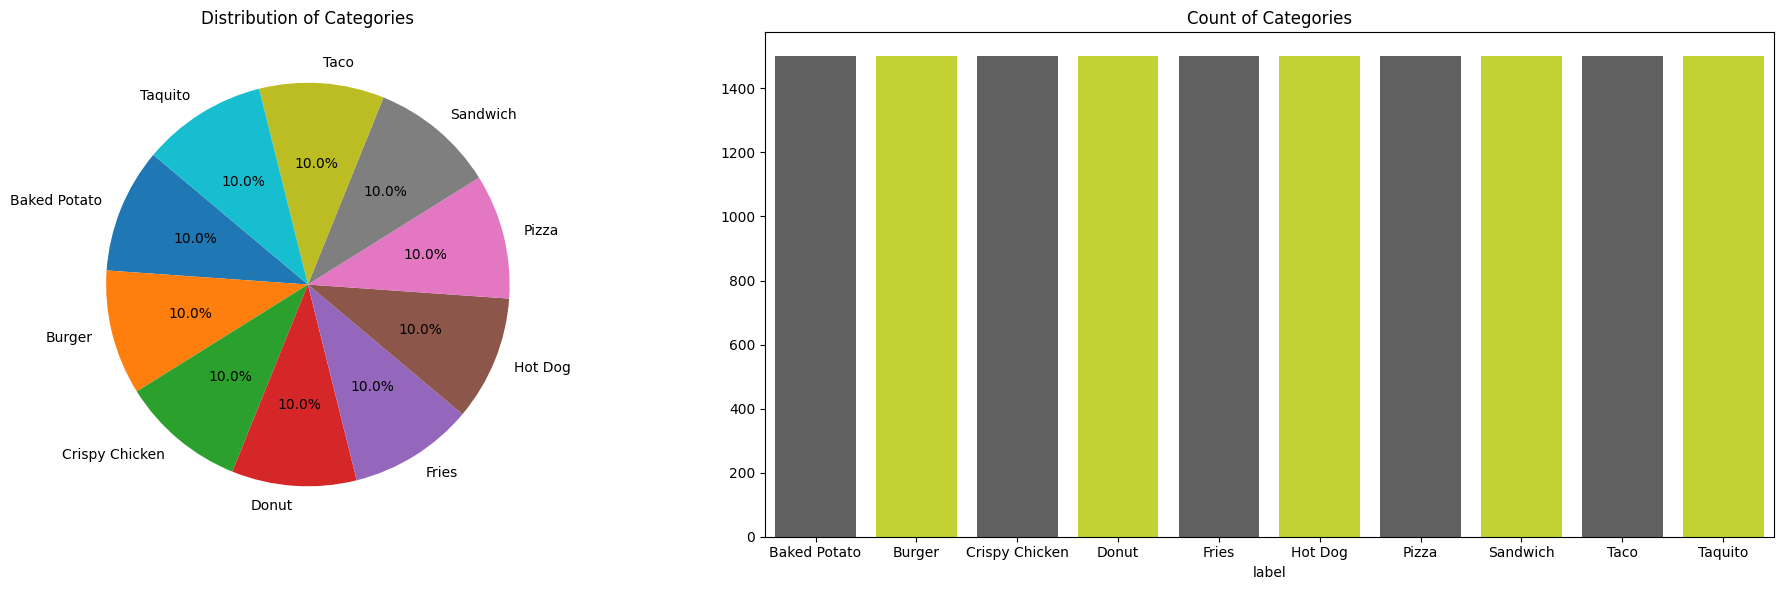

In [ ]:
# Train Count
Count_S(tr_d, custom_palette)

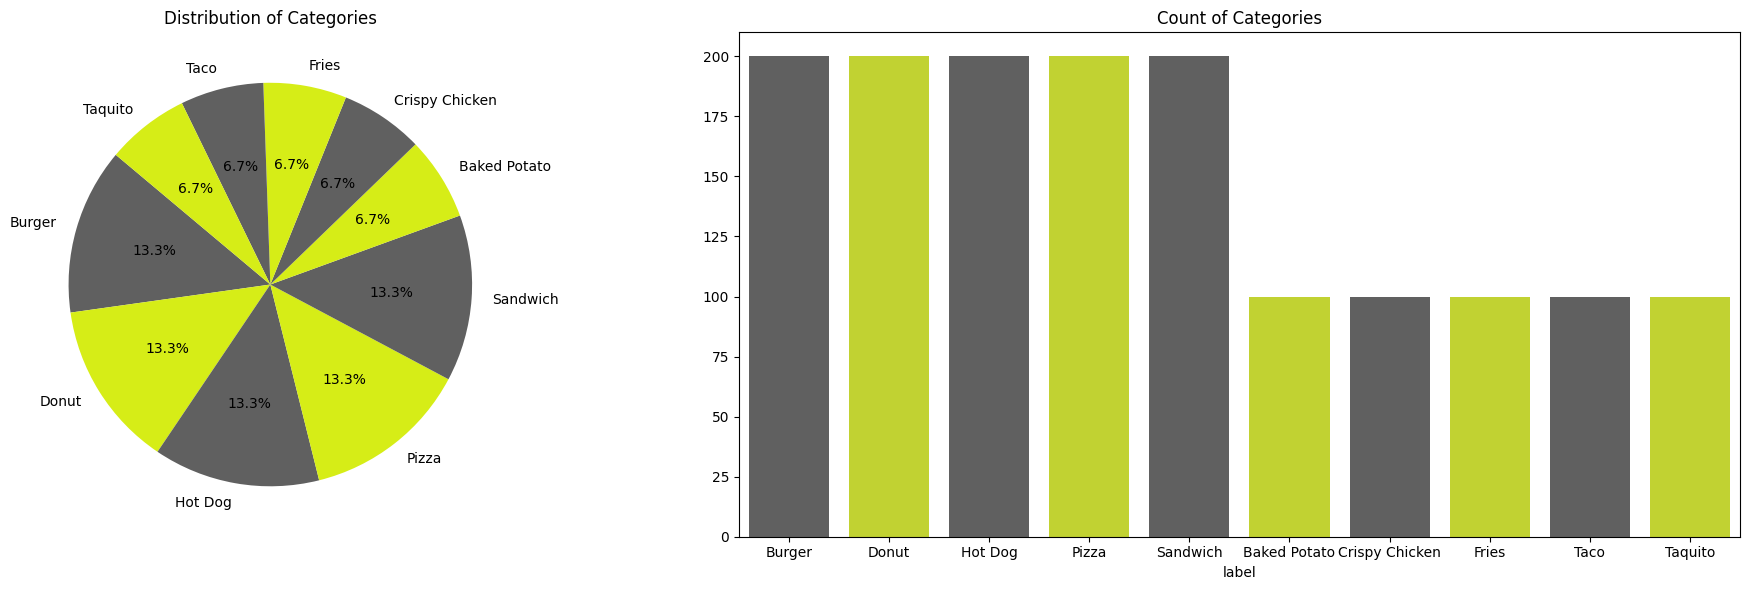

In [ ]:
# Test Count
Count_S(te_d, custom_palette)

In [ ]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)

    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))

    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')

    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

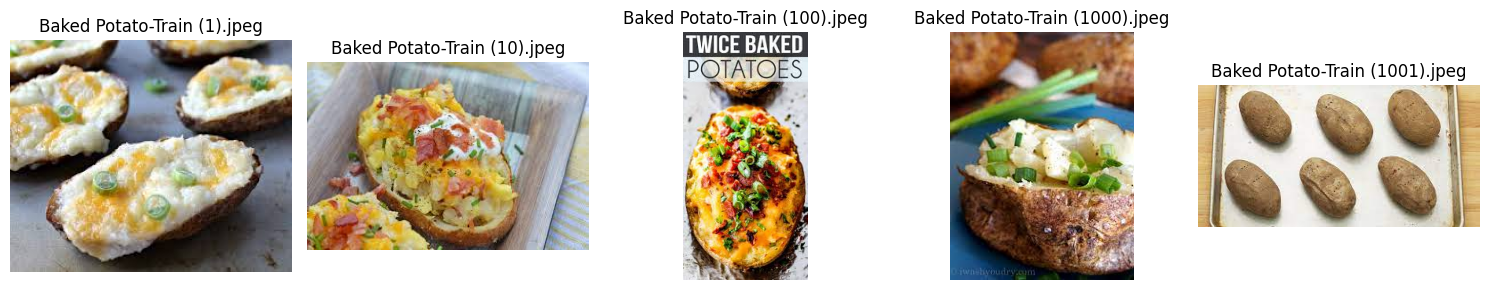

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fast-food-classification-dataset/Fast Food Classification V2/Train/Baked Potato"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

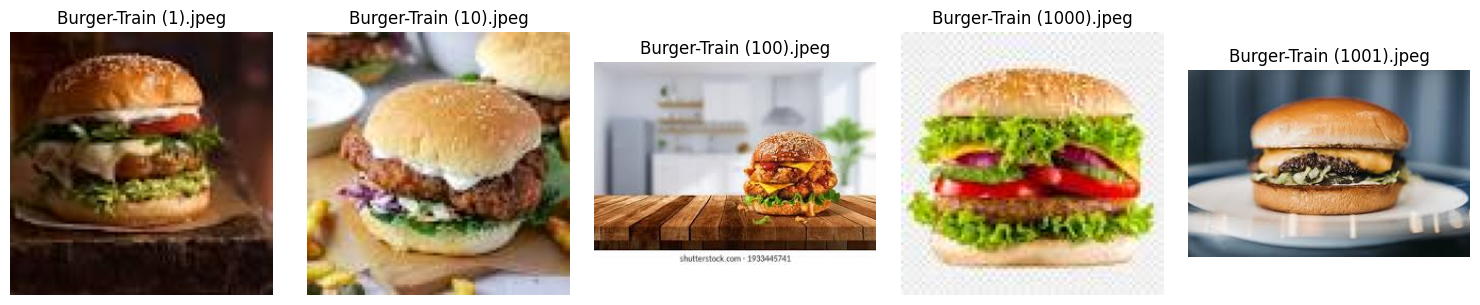

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fast-food-classification-dataset/Fast Food Classification V2/Train/Burger"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

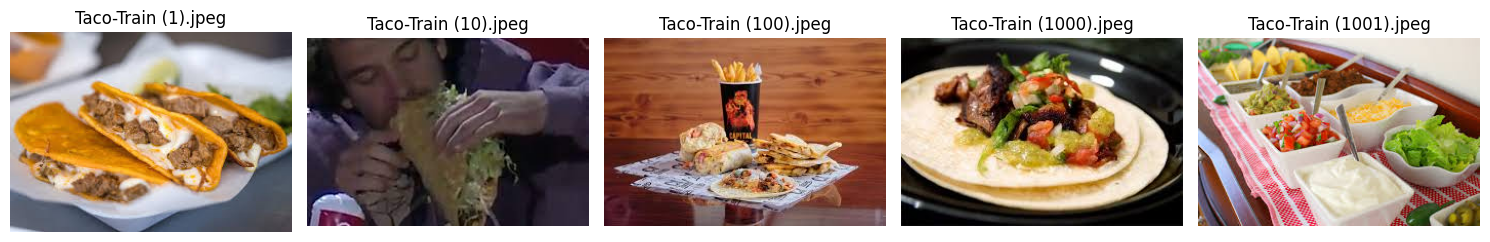

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fast-food-classification-dataset/Fast Food Classification V2/Train/Taco"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

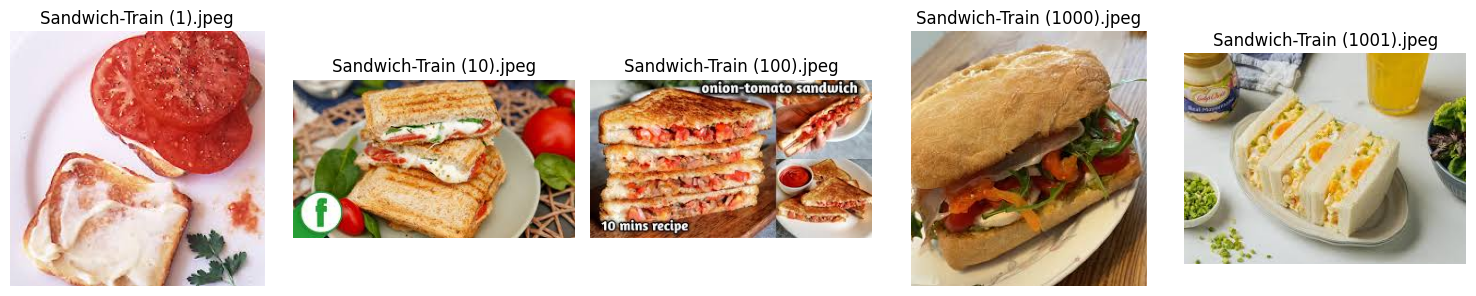

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fast-food-classification-dataset/Fast Food Classification V2/Train/Sandwich"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

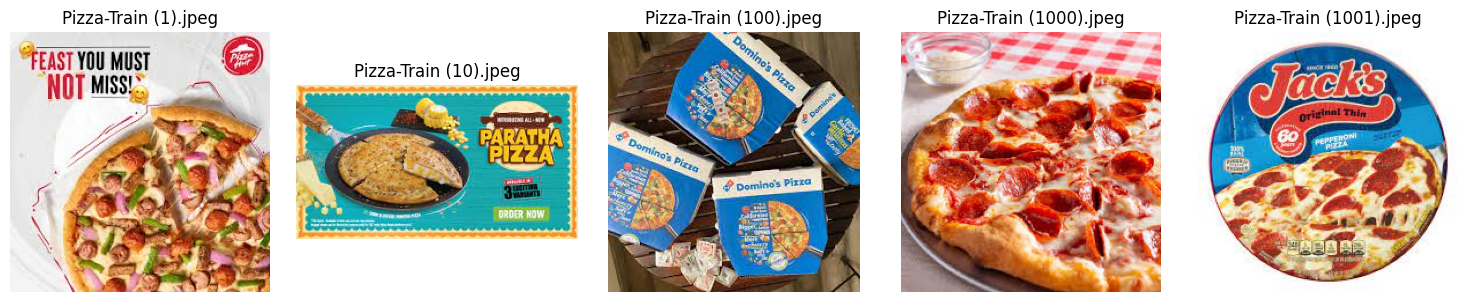

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fast-food-classification-dataset/Fast Food Classification V2/Train/Pizza"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

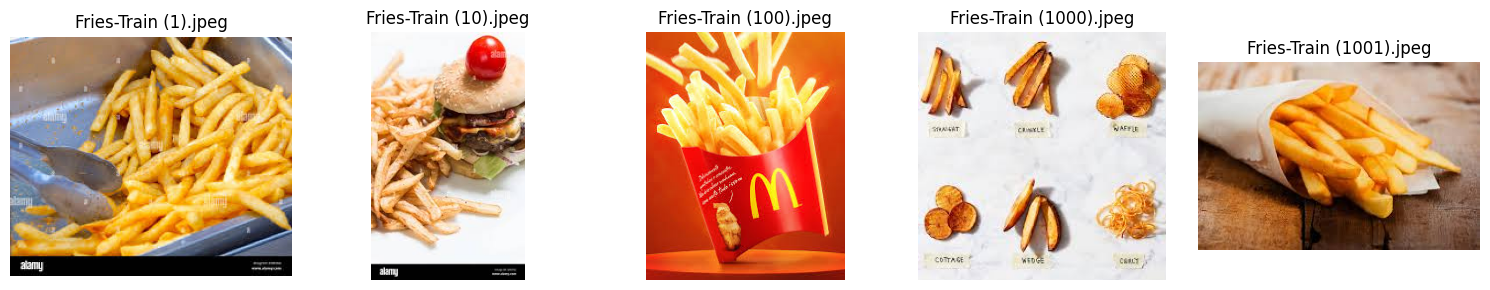

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/fast-food-classification-dataset/Fast Food Classification V2/Train/Fries"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [ ]:
# Define the URL of the model
url = "https://tfhub.dev/google/bit/m-r50x1/1"


local_url = "/content/drive/MyDrive/fast-food-classification-dataset/MyModel"

# Load the model from the URL
model_E = hub.KerasLayer(url)

# Set the model to be non-trainable
model_E.trainable = False

In [ ]:
def createModel1(model_E, EPO):
    # Define the name for your model
    model_name = "FoodClassificationModel"

    # Create a functional model instead of Sequential
    inputs = keras.Input(shape=(256, 256, 3))  # Assuming your input shape

    # Preprocess the input for the TensorFlow Hub model if necessary
    x = tf.keras.applications.resnet50.preprocess_input(inputs)

    # Wrap the TensorFlow Hub model in a Lambda layer to handle symbolic inputs
    x = Lambda(lambda x: model_E(x))(x)  # Pass inputs through the KerasLayer

    # Give the BatchNormalization layer a custom, valid name
    x = BatchNormalization(name='batch_norm_layer')(x)  # Change the layer name here
    x = Dropout(0.2)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    # Compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    print(model.summary())

    # Early_Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fitting Model - Use model.fit() instead of model.fit_generator()
    history = model.fit(train_ds,
                        epochs=EPO,
                        validation_data=validation_ds,
                        callbacks=early_stopping)

    return history



In [ ]:
#history = M_B(model_E, 6)
history = createModel1(model_E, 6)

Model: "FoodClassificationModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 256, 256, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 256, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 2048)           │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_norm_layer          │ (None, 2048)           │          8,192 │ lambda_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 2048)           │              0 │ batch_norm_layer[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 10)             │         20,490 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 28,682 (112.04 KB)

 Trainable params: 24,586 (96.04 KB)

 Non-trainable params: 4,096 (16.00 KB)

None
Epoch 1/6
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.1950 - loss: 2.4238 

In [ ]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

In [ ]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()